<a href="https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/antoniovfonseca/agentic-ai-global-lulc/blob/main/notebooks/overview-glance.ipynb)

## **1. Import of geospatial processing and visualization modules.**
---



In [ ]:
# Enter your Google Cloud Project ID
project_id = "ee-antoniovicgf"

In [22]:
import os
import sys
import warnings

from google.colab import files
import os
import logging
import ee
import ee
import geemap
import numpy as np
import rasterio
from rasterio.warp import reproject
from rasterio.warp import Resampling
from rasterio.warp import transform_bounds

# Filter future warnings to keep output clean
warnings.simplefilter(action='ignore', category=FutureWarning)

# Install geemap dependency
print("Installing dependencies...")
!pip install geemap -q
!pip install localtileserver -q

# Define repository details
repo_url = 'https://github.com/antoniovfonseca/agentic-ai-global-lulc.git'
repo_name = 'agentic-ai-global-lulc'

# Clone or update the repository
if not os.path.exists(repo_name):
    print(f"Cloning {repo_name}...")
    !git clone {repo_url}
else:
    print(f"Updating {repo_name}...")
    !cd {repo_name} && git pull

# Add the notebooks directory to system path to allow imports
notebooks_path = os.path.join(repo_name, 'notebooks')
if notebooks_path not in sys.path:
    sys.path.append(os.path.abspath(notebooks_path))
    print(f"Added {notebooks_path} to system path.")

import importlib
import utils

importlib.reload(utils)
print("Utils module loaded successfully.")

Installing dependencies...
Updating agentic-ai-global-lulc...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.08 KiB | 1.08 MiB/s, done.
From https://github.com/antoniovfonseca/agentic-ai-global-lulc
   56ff345..6f8de17  main       -> origin/main
Updating 56ff345..6f8de17
Fast-forward
 notebooks/utils.py | 61 ++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 61 insertions(+)
Added agentic-ai-global-lulc/notebooks to system path.
Utils module loaded successfully.


If you are running this notebook in Google Colab, please uncomment and run the following cell to install the required packages.

## **2. Earth Engine session authentication and initialization.**


---
See the Google instructions [here](https://developers.google.com/earth-engine/guides/auth).


In [16]:
# Authenticate and initialize earth engine
try:
    # Try initializing with the provided project id or default
    if project_id:
        ee.Initialize(project=project_id)
    else:
        ee.Initialize()
    print("Earth Engine initialized successfully.")

except Exception:
    # Trigger authentication flow if initialization fails
    print("Authentication required...")
    ee.Authenticate()

    try:
        # Retry initialization after authentication
        if project_id:
            ee.Initialize(project=project_id)
        else:
            ee.Initialize()
        print("Earth Engine initialized successfully.")

    except ee.EEException:
        # Fallback to manual input if no project is found
        print("No default project found.")
        manual_id = input("Please enter your Google Cloud Project ID: ")
        ee.Initialize(project=manual_id)
        print("Earth Engine initialized successfully.")

Earth Engine initialized successfully.


## **3. Definition of the remote GLANCE dataset source.**

In [18]:
# Define parameters
target_year = 2019

# Run the function imported from utils.py
glance_map = utils.get_glance_map(target_year)

# Display the map
if glance_map:
    display(glance_map)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## **4. .**

In [ ]:
# Section 4: Upload Raster File
print("Please upload your raster file (.tif):")

# This triggers the file upload widget
uploaded = files.upload()

# Automatically get the filename of the uploaded file
if uploaded:
    raster_filename = list(uploaded.keys())[0]
    print(f"\nFile '{raster_filename}' uploaded successfully.")
else:
    raise ValueError("No file uploaded. Please run the cell again and select a file.")

In [27]:
# Suppress warnings
logging.getLogger('googleapiclient.http').setLevel(logging.ERROR)
logging.getLogger('urllib3.connectionpool').setLevel(logging.ERROR)

# Install geedim if missing
try:
    import geedim
except ImportError:
    print("Installing geedim...")
    !pip install geedim -q

# Define directories
masked_dir = utils.DEFAULT_INPUT_DIR
base_dir = os.path.dirname(masked_dir)
raw_dir = os.path.join(base_dir, 'raw')


# Create directories if they do not exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(masked_dir, exist_ok=True)

# Define processing parameters
years = [2001, 2010, 2019]

# Get geometry from local mask
with rasterio.open(raster_filename) as src:
    left, bottom, right, top = src.bounds
    if src.crs != 'EPSG:4326':
        left, bottom, right, top = transform_bounds(
            src.crs,
            'EPSG:4326',
            left,
            bottom,
            right,
            top
        )
    region = ee.Geometry.Rectangle([left, bottom, right, top])

# Process each year
for year in years:
    filename = f"glance_{year}.tif"
    raw_path = os.path.join(raw_dir, filename)
    masked_path = os.path.join(masked_dir, filename)

    # Skip if final masked file exists
    if os.path.exists(masked_path):
        print(f"Skipping {year} (masked file exists).")
        continue

    print(f"Processing year {year}...")

    # 1. Download raw data to raw folder
    if not os.path.exists(raw_path):
        try:
            image = ee.ImageCollection(utils.GLANCE_COLLECTION_ID) \
                .filterDate(f"{year}-01-01", f"{year}-12-31") \
                .mosaic() \
                .select(utils.GLANCE_CLASS_BAND) \
                .clip(region)

            geemap.download_ee_image(
                image,
                filename=raw_path,
                region=region,
                scale=30,
                crs='EPSG:4326',
                unmask_value=0,
                num_threads=1
            )
        except Exception as e:
            print(f"Error downloading {year}: {e}")
            continue

    # 2. Apply local mask and save to masked folder
    try:
        with rasterio.open(raster_filename) as mask_src:
            mask_data = mask_src.read(1)
            kwargs = mask_src.profile.copy()

            with rasterio.open(raw_path) as glance_src:
                glance_aligned = np.zeros(
                    mask_data.shape,
                    dtype=np.uint8
                )

                reproject(
                    source=rasterio.band(glance_src, 1),
                    destination=glance_aligned,
                    src_transform=glance_src.transform,
                    src_crs=glance_src.crs,
                    dst_transform=mask_src.transform,
                    dst_crs=mask_src.crs,
                    resampling=Resampling.nearest
                )

        # Apply mask logic (1 keeps value, others become 255)
        final_data = np.full(mask_data.shape, utils.NODATA_VALUE, dtype=np.uint8)
        valid_pixels = (mask_data == 1)
        final_data[valid_pixels] = glance_aligned[valid_pixels]

        # Update profile: fix block size to avoid "multiples of 16" error
        kwargs.update(
            dtype=rasterio.uint8,
            nodata=utils.NODATA_VALUE,
            compress='deflate',
            predictor=2,
            tiled=True,
            blockxsize=256,
            blockysize=256
        )

        with rasterio.open(masked_path, 'w', **kwargs) as dst:
            dst.write(final_data, 1)

        print(f"Finished: {masked_path}")

    except Exception as e:
        print(f"Error masking {year}: {e}")

Processing year 2001...


  0%|          |0/164 tiles [00:00<?]

Finished: /content/glance_data/masked/glance_2001.tif
Processing year 2010...


  0%|          |0/164 tiles [00:00<?]

Finished: /content/glance_data/masked/glance_2010.tif
Processing year 2019...


  0%|          |0/164 tiles [00:00<?]

Finished: /content/glance_data/masked/glance_2019.tif


Starting processing...
Pixel counts per time point and class:
ClassName  Barren  Developed  Herbaceous     Shrub    Trees  Water
Year                                                              
2001       162892      67980    16901516  47839633  8727588  30934
2010       176131      70553    22504467  43259711  7689932  29749
2019       142967      71426    28181158  39672085  5637200  25707


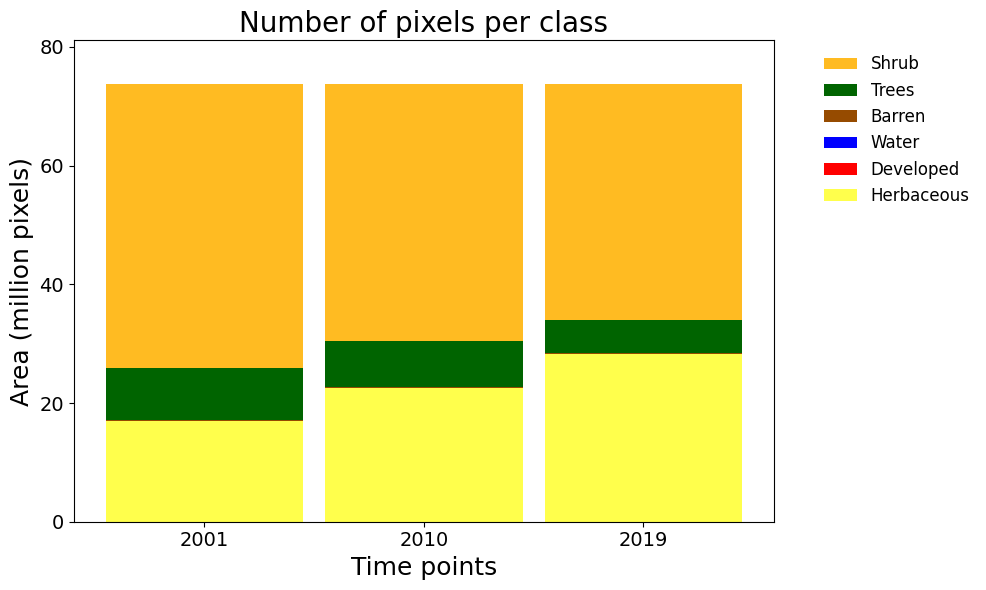

Files saved to: /content/glance_data/output

Processing complete. Data summary:


ClassName,Barren,Developed,Herbaceous,Shrub,Trees,Water
Year,,,,,,
2001,162892,67980,16901516,47839633,8727588,30934
2010,176131,70553,22504467,43259711,7689932,29749
2019,142967,71426,28181158,39672085,5637200,25707


In [28]:
print("Starting processing...")

# Run the function using default settings from utils.py
df_result = utils.process_and_plot_pixel_counts()

# Display results if successful
if df_result is not None:
    print("\nProcessing complete. Data summary:")
    display(df_result)

In [30]:
# View processed local files
m = utils.view_local_rasters()

if m:
    display(m)

Loading 3 local raster layers...


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **4. Change Component Analysis (CCA)**


---

